### Import Modules and Define Functions

#### Import Modules

In [1]:
import os
import pickle
import numpy as np
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import tensorflow as tf
# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
tf.__version__ # printint out tensorflow version used

'2.10.0'

In [3]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy 

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

stable_baselines3.__version__ # printing out stable_baselines version used

C:\Users\wanha\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.7.0'

In [4]:
import gym

In [5]:
import os
import numpy as np
import pickle
import gym
import pandas as pd
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy as MLP_PPO
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy as MLP_DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
#from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import seaborn as sns
from explainable.utils import evaluate_policy
#from explainable.envs.deeprmsa_env import shortest_available_path_first_fit
from explainable.dagger import DAgger_Policy
stable_baselines3.__version__ # printing out stable_baselines version used

'1.7.0'

#### Define functions

In [6]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps),end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

In [7]:
def get_EnvExpert(top_name, k, alg_name, base_log_dir='./tmp/', only_spectrum_obs = False, mean_service_holding_time=10):
    topology_dir = '/topologies/demo/' +  top_name +f'_{k}.h5'
    with open(f'..{topology_dir}', 'rb') as f:
        topology = pickle.load(f)
    assert k <= topology.graph['k_paths']
    
    node_request_probabilities = np.array([1/11, 1/11, 1/11, 1/11,
                                       1/11, 1/11, 1/11, 1/11,
                                       1/11, 1/11, 1/11])

    env_args = dict(topology=topology, seed=10, 
                    allow_rejection=False, # the agent cannot proactively reject a request
                    k_paths = k,
                    j=1, # consider only the first suitable spectrum block for the spectrum assignment
                    mean_service_holding_time=mean_service_holding_time, # value is not set as in the paper to achieve comparable reward values
                    episode_length=50, node_request_probabilities=node_request_probabilities, num_spectrum_resources = 358)

    # Create log dir
    log_dir = "./tmp_kpath/deeprmsa-dqn-sbpp-agent-{}-cost239/".format(k)
    env = gym.make('DeepRMSAKSP-v0', **env_args)

    # logs will be saved in log_dir/monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking probabilities
    env = Monitor(env, log_dir + 'testing', info_keywords=('episode_service_blocking_rate','bit_rate_blocking_rate','failure', 'episode_failure',
                        'failure_slots','episode_failure_slots', 
                        'failure_disjointness','episode_failure_disjointness', 'failure_shared_disjointness',
                        'episode_failure_shared_disjointness','shared_counter','episode_shared_counter', 'dpp_counter',
                        'episode_dpp_counter','compactness', 'throughput', 'available_slots_working', 'available_slots_backup'))
    
    expert = DQN.load(log_dir +'best_model')
        
    return env, expert

### Training Heursitics

In [8]:
k_paths = [1, 2, 3, 4, 5, 10]

for k_path in k_paths:
    alg_name = 'DQN'
    top_name = 'cost239'

    topology_dir = '/topologies/demo/' +  top_name +f'_{k_path}.h5'
    with open(f'..{topology_dir}', 'rb') as f:
        topology = pickle.load(f)

    node_request_probabilities = np.array([1/11, 1/11, 1/11, 1/11,
                                        1/11, 1/11, 1/11, 1/11,
                                        1/11, 1/11, 1/11])

    env_args = dict(topology=topology, seed=10, 
                    allow_rejection=False, # the agent cannot proactively reject a request
                    k_paths = k_path,
                    j=1, # consider only the first suitable spectrum block for the spectrum assignment
                    mean_service_holding_time=10, # value is not set as in the paper to achieve comparable reward values
                    episode_length=50, node_request_probabilities=node_request_probabilities, num_spectrum_resources = 358)

    # Create log dir
    log_dir = "./tmp_kpath/deeprmsa-dqn-sbpp-agent-{}-cost239/".format(k_path)
    os.makedirs(log_dir, exist_ok=True)
    callback = SaveOnBestTrainingRewardCallback(check_freq=50, log_dir=log_dir)

    env = gym.make('DeepRMSAKSP-v0', **env_args)

    # logs will be saved in log_dir/monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking probabilities
    env = Monitor(env, log_dir + 'testing', info_keywords=('episode_service_blocking_rate','bit_rate_blocking_rate','failure', 'episode_failure',
                        'failure_slots','episode_failure_slots', 
                        'failure_disjointness','episode_failure_disjointness', 'failure_shared_disjointness',
                        'episode_failure_shared_disjointness','shared_counter','episode_shared_counter', 'dpp_counter',
                        'episode_dpp_counter','compactness', 'throughput', 'available_slots_working', 'available_slots_backup'))

    # kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)} # set of parameters for testing
    policy_kwargs = dict(net_arch=4*[128])  

    model = DQN(MlpPolicy, env, verbose=0, tensorboard_log="./tb_kpath/DQN-sbpp-agent-{}-cost239-DeepRMSA-v0/".format(k_path), gamma=0.85, policy_kwargs=policy_kwargs,
            learning_rate=0.0001, exploration_fraction=0.01, batch_size = 256, buffer_size = 50000)

    training_m = model.learn(total_timesteps=5000, callback=callback)

Num timesteps: 5000 - Best mean reward: 69.00 - Last mean reward per episode: 54.28


### Evaluate Heuristics

#### Define Variables

In [9]:
alg_name = 'DQN'
top_name = 'cost239'
traffics = [100, 200, 300, 400, 500, 600]
holding_time = [10, 20, 30, 40, 50, 60]
n_eval_episodes = 500

In [11]:
import time as t

rewards = {
    '1-SPFF':[],
    '2-SPFF':[],
    '3-SPFF':[],
    '4-SPFF':[],
    '5-SPFF':[],
    '10-SPFF':[]      
} 
blocking_rates = {
    '1-SPFF':[],
    '2-SPFF':[],
    '3-SPFF':[],
    '4-SPFF':[],
    '5-SPFF':[],
    '10-SPFF':[]  
} 
failure_slots = {
    '1-SPFF':[],
    '2-SPFF':[],
    '3-SPFF':[],
    '4-SPFF':[],
    '5-SPFF':[],
    '10-SPFF':[]  
} 
failure_disjointness = {
    '1-SPFF':[],
    '2-SPFF':[],
    '3-SPFF':[],
    '4-SPFF':[],
    '5-SPFF':[],
    '10-SPFF':[]   
} 
evaluation_time = {
    '1-SPFF':[],
    '2-SPFF':[],
    '3-SPFF':[],
    '4-SPFF':[],
    '5-SPFF':[],
    '10-SPFF':[]   
}


for ht in holding_time:  
    for key in rewards:
        if key == '1-SPFF':
            env, expert = get_EnvExpert(top_name, 1, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
        elif key == '2-SPFF':
            env, expert = get_EnvExpert(top_name, 2, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
        elif key == '3-SPFF':
            env, expert = get_EnvExpert(top_name, 3, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)     
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)    
        elif key == '4-SPFF':
            env, expert = get_EnvExpert(top_name, 4, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
        elif key == '5-SPFF':
            env, expert = get_EnvExpert(top_name, 5, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
        elif key == '10-SPFF':
            env, expert = get_EnvExpert(top_name, 10, alg_name, mean_service_holding_time=ht)
            start = t.time()
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
        else:
            raise Exception("\n\nSorry, key not found")

        
        evaluation_time[key].append(timer)
        rewards[key].append(mean_reward)
        blocking_rates[key].append(df['service_blocking_rate'][len(df['service_blocking_rate'])-1])
        
        print(f'Done for {key} with expert mean_reward = {mean_reward} with duration of {timer} minutes')

Done for 1-SPFF with expert mean_reward = -50.0 with duration of 0.32 minutes
Done for 2-SPFF with expert mean_reward = 33.296 with duration of 1.51 minutes
Done for 3-SPFF with expert mean_reward = 48.54 with duration of 1.83 minutes
Done for 4-SPFF with expert mean_reward = 50.084 with duration of 1.94 minutes
Done for 5-SPFF with expert mean_reward = 52.25 with duration of 2.03 minutes
Done for 10-SPFF with expert mean_reward = 54.254 with duration of 2.38 minutes
Done for 1-SPFF with expert mean_reward = -50.0 with duration of 0.33 minutes
Done for 2-SPFF with expert mean_reward = 23.598 with duration of 1.47 minutes
Done for 3-SPFF with expert mean_reward = 29.752 with duration of 1.65 minutes
Done for 4-SPFF with expert mean_reward = 30.892 with duration of 1.76 minutes
Done for 5-SPFF with expert mean_reward = 33.514 with duration of 1.88 minutes
Done for 10-SPFF with expert mean_reward = 37.332 with duration of 2.34 minutes
Done for 1-SPFF with expert mean_reward = -50.0 with d

#### Saving Results

In [12]:
os.makedirs('./plots_kpaths/', exist_ok=True)

df_r = pd.DataFrame(rewards)
df_r.to_csv(f'./plots_kpaths/rewards_ksp_{k_path}.csv')
df_r = pd.DataFrame(blocking_rates)
df_r.to_csv(f'./plots_kpaths/blocking_rates_ksp_{k_path}.csv')
df_r = pd.DataFrame(evaluation_time)
df_r.to_csv(f'./plots_kpaths/evaluation_time_ksp_{k_path}.csv')

### Plot of Results

#### Blocking rate

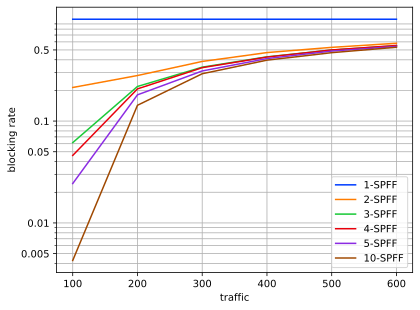

In [13]:
base_output_dir = './plots_kpaths/blocking_rate/'
colors = sns.color_palette("bright")

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(blocking_rates):
    plt.plot(traffics, blocking_rates[key], label=key, color=colors[i])
plt.xlabel("traffic")
plt.ylabel("blocking rate")
plt.legend(loc = "lower right")
plt.yscale('log')
plt.grid(axis='both', which='both')
plt.yticks(ticks=[5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2],labels=[ 5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2])
# plt.yticks(ticks=[x/100 for x in range(1, 25,5)],labels=[x/100 for x in range(1, 25,5)])
plt.savefig(output_dir + f'{top_name}_{k_path}_ksp.png')
plt.show()

#### Rewards

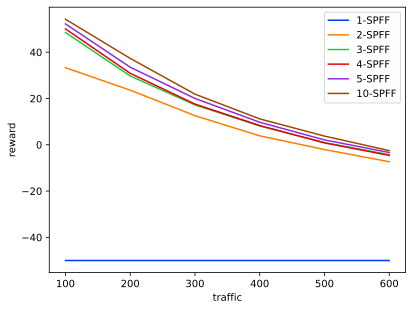

In [18]:
base_output_dir = './plots_kpaths/rewards/'
colors = sns.color_palette("bright")

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(traffics, rewards[key], label=key, color=colors[i])
plt.xlabel("traffic")
plt.ylabel("reward")
plt.legend()
plt.savefig(output_dir + f'{top_name}_{k_path}_ksp.png')
plt.show()

#### Evaluation Time

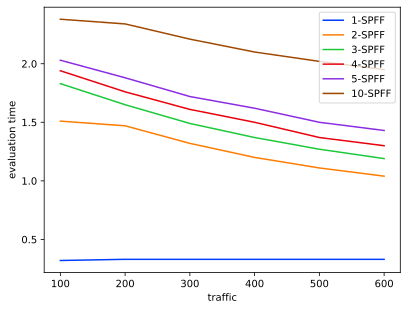

In [17]:
base_output_dir = './plots_kpaths/evaluation_time/'
colors = sns.color_palette("bright")

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(traffics, evaluation_time[key], label=key, color=colors[i])
plt.xlabel("traffic")
plt.ylabel("evaluation time")
plt.legend()
plt.savefig(output_dir + f'{top_name}_{k_path}_ksp.png')
plt.show()